## Load libraries

In [2]:
library(plyr)
library(dplyr)
library(ggplot2)
library(ComplexHeatmap)
library(circlize)
library(reshape)
library(reshape2)
library(ChIPseeker)
library(org.Hs.eg.db)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(org.Hs.eg.db)
library(Signac)
library(tidyverse)
library(data.table)
library(repr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppre

## Set paths to reference files

In [3]:
cancers=c('ccRCC','CRC','CESC','HNSCC','UCEC','GBM','BRCA','OV','MM','PDAC','SKCM')

#ATAC project color scales
path_to_ATAC_colors='../data/Colors_panatac_v2.0.rds'

#Matrix with accessibility averaged per tumor cells from each sample, and per normal cells from tissue
path_to_ATAC_average_matrix='../data/snATAC/Average_accessibility_matrix.DataSlot.20230212.tsv'

#Cell counts per each cell group in matrix with average ATAC accessibility
path_to_ATAC_average_matrix_meta='../data/snATAC/Cell_count_perGroup.forAverageAccessibilityMatrix.20230212.tsv'

#ATAC catalog
path_to_ATAC_catalog='../data/ATAC_catalog.20220114.v2.txt'

#Tissue- and cancer-specific DACRs, Supplementary Table S2a
path_to_ATAC_tiss_can_DACRs='../data/snATAC/Table_S2a_tiss_cancer_DACRs.txt' 

#Tissue- and cancer-specific DEGs, Supplementary Table S2b
path_to_RNA_tiss_can_DEGs='../data/snRNA/Table_S2b_tiss_cancer_DEGs.txt'

## Set color scales

In [4]:
cols=readRDS(path_to_ATAC_colors)

dis_cols_ed <- cols$Cancer
dis_cols_ed=c('#C69158',dis_cols_ed)
names(dis_cols_ed)[1]='CEAD'

tiss_cols=c("Tumor"="#377EB8","Normal"="#4DAF4A","Met"="#E41A1C")

In [5]:
#Read catalog
cat=read_delim('/Users/nadezhdaterekhanova/Desktop/Projects/ATAC/PanCan_ATAC/Analysis/Updated_pipeline/DATA/data_freeze.v.7.0/ATAC_catalog.20220114.v2.txt',delim='\t')
cat=as.data.frame(cat)
colnames(cat)=gsub(' ','_',colnames(cat))

cat$Piece_ID=paste(cat$Disease_Type,cat$Piece_ID,sep='_')
cat=cat %>% dplyr::select ('Piece_ID','Sample_Type')
colnames(cat)[2]=c('Sample_type')


Rows: 225 Columns: 12
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (10): Disease Type, Sample ID, Case ID, Piece_ID, Sample Type, Data Type...
lgl  (2): Include in the downstream analysis, Include in immune

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
#Read average accessibility matrix
tab_1=fread(path_to_ATAC_average_matrix)
tab_1=as.data.frame(tab_1)
rownames(tab_1)=tab_1[,1]
tab_1=tab_1[,-1]

#Remove cell groups with too few number of cells
meta=read.table(path_to_ATAC_average_matrix_meta,sep='\t',header=T)
meta_s=meta[meta$Cell_count>=20,]

Warning message in fread(path_to_ATAC_average_matrix):
“Detected 245 column names but the data has 246 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [7]:
#Subset data for tumor cells
tab_1=tab_1[,grepl('^Tumor_',colnames(tab_1))]
tab=tab_1
tab=t(tab)

tab=tab[rownames(tab) %in% meta_s$Cell_type,]

In [8]:
#Add row annotation
row_annot=as.data.frame(rownames(tab))
colnames(row_annot)='ID'
row_annot$Cell_type=gsub('(.*)__(.*)_(.*)','\\1',row_annot$ID)
row_annot$Disease=gsub('(.*)__(.*)_(.*)','\\2',row_annot$ID)
row_annot$Piece_ID=gsub('Tumor__','',row_annot$ID)
row_annot$Disease=gsub('(.*)_.*','\\1',row_annot$Disease)

#Annotate BRCA basal samples
row_annot$Disease=ifelse(row_annot$Piece_ID %in% 
                         paste('BRCA',c("HT029B1-S1PC","HT035B1-S1PA","HT141B1-S1H1","HT206B1-S1H4","HT1408-06","HT268B1-Th1H3","HT271B1-S1H3","HT378B1-S1H1", "HT378B1-S1H2", "HT384B1-S1H1", "HT517B1-S1H1"),sep='_'),
                         'BRCA_Basal',row_annot$Disease)
row_annot$Disease_2=row_annot$Disease

#Annotate CEAD samples
row_annot$Disease_2=ifelse(row_annot$Piece_ID %in% 
                           c('CESC_CE332E1-N1','CESC_CE336E1-S1','CESC_CE354E1-S1','CESC_CE357E1-S1','CESC_CE507-C1A2'),
                           'CEAD',row_annot$Disease_2)
row_annot$ID_2=paste(row_annot$Disease,row_annot$Cell_type,sep='_')
rownames(row_annot)=row_annot$ID


#Also add annotation from the ATAC catalog
row_annot=merge(row_annot, cat,all.x=T)
rownames(row_annot)=row_annot$ID
annot=row_annot

#Set the same order in the accessibility matrix
tab=tab[rownames(row_annot),]

In [9]:
#Scale accessibility matrix
to_plot=scale(tab)

In [10]:
#Read tissue- and cancer-specific DACRs
mark=read.table(path_to_ATAC_tiss_can_DACRs,sep='\t',header=T)
mark=mark[mark$p_val_adj<0.05,]


#Keep the strongest peak-cancer pair (by Fch)
mark=mark[order(-mark$avg_log2FC),]
mark=mark[!duplicated(mark$peak),]

In [11]:
#Select top 500 or less by Fold change DACRs for each cancer, and then filter for most specific ones across samples.
all_x_s=NULL
cancers_ed=c('ccRCC','CRC','CESC','HNSCC','UCEC','GBM','BRCA','OV','MM','PDAC','BRCA_Basal','SKCM')
for (can in cancers_ed){
    annot_s=annot[annot$Disease==can,]
    mark_s=mark[mark$Cancer==can,][1:500,]
    t_s=to_plot[rownames(annot_s),colnames(to_plot) %in% mark_s$peak]
    x=apply(t_s,2,function(x) length(x[x>0]))
    x_s=as.data.frame(x[x>0.7*nrow(t_s)])
    x_s$Disease=can
    x_s$peak=rownames(x)
    all_x_s=rbind(all_x_s,x_s)
    print(can)
}
all_x_s=as.data.frame(all_x_s)
all_x_s$peak=rownames(all_x_s)

#Make accessibility matrix with only those selected DACRs            
to_plot_1=to_plot[,colnames(to_plot) %in% all_x_s$peak]

[1] "ccRCC"
[1] "CRC"
[1] "CESC"
[1] "HNSCC"
[1] "UCEC"
[1] "GBM"
[1] "BRCA"
[1] "OV"
[1] "MM"
[1] "PDAC"
[1] "BRCA_Basal"
[1] "SKCM"


In [12]:
#Set order of rows for heatmap by cancer and by sample type
annot$can_ID=1
annot$can_ID=ifelse(annot$Disease_2=='HNSCC',1,annot$can_ID)
annot$can_ID=ifelse(annot$Disease_2=='CESC',2,annot$can_ID)
annot$can_ID=ifelse(annot$Disease_2=='CEAD',3,annot$can_ID)
annot$can_ID=ifelse(annot$Disease_2=='PDAC',4,annot$can_ID)
annot$can_ID=ifelse(annot$Disease_2=='CRC',5,annot$can_ID)
annot$can_ID=ifelse(annot$Disease_2=='MM',6,annot$can_ID)
annot$can_ID=ifelse(annot$Disease_2=='BRCA',7,annot$can_ID)
annot$can_ID=ifelse(annot$Disease_2=='BRCA_Basal',8,annot$can_ID)
annot$can_ID=ifelse(annot$Disease_2=='OV',9,annot$can_ID)
annot$can_ID=ifelse(annot$Disease_2=='UCEC',10,annot$can_ID)
annot$can_ID=ifelse(annot$Disease_2=='GBM',11,annot$can_ID)
annot$can_ID=ifelse(annot$Disease_2=='ccRCC',12,annot$can_ID)
annot$can_ID=ifelse(annot$Disease_2=='SKCM',13,annot$can_ID)

annot=annot[order(annot$Sample_type),]
annot=annot[order(annot$can_ID),]

to_plot_1=to_plot_1[rownames(annot),]

In [13]:
#Annotate DACRs using ChIPseeker
tab=to_plot_1
peaks_1=StringToGRanges(colnames(tab), sep = c("-", "-"))

peakAnno <- annotatePeak(peaks_1, tssRegion=c(-1000, 100),
                         TxDb=TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb="org.Hs.eg.db")
anno=as.data.frame(peakAnno)

#Add DACRs annotation
peaks=as.data.frame(colnames(tab))
colnames(peaks)='peak'
peaks$Gene=anno$SYMBOL
peaks$Type=anno$annotation
peaks$geneId=anno$geneId
peaks$peak_distanceToTSS=anno$distanceToTSS
peaks$geneID=anno$geneID
peaks$Type_2=gsub('(.*) \\(.*','\\1',peaks$Type)
peaks$annot=ifelse(peaks$Type_2 %in% c('Promoter'),peaks$Gene,'')

#Also add cancer-specificity annotation
peaks=merge(peaks,all_x_s[,-1],all.x=T)


>> preparing features information...		 2023-05-14 20:59:13 
>> identifying nearest features...		 2023-05-14 20:59:14 
>> calculating distance from peak to TSS...	 2023-05-14 20:59:15 
>> assigning genomic annotation...		 2023-05-14 20:59:15 
>> adding gene annotation...			 2023-05-14 20:59:30 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2023-05-14 20:59:30 
>> done...					 2023-05-14 20:59:30 


In [14]:
peaks_pr=peaks[peaks$Type=='Promoter',]
peaks_pr=peaks_pr[,c('peak','Type','Disease','Gene')]
degs=read.table(path_to_RNA_tiss_can_DEGs,sep='\t',header=T)
degs=degs[degs$avg_log2FC>0 & degs$p_val_adj<0.05,]
colnames(degs)[5]=c('Disease')

#Keep only DEGs that have promoters among selected DACRs
degs=merge(degs,peaks_pr)

#Remove duplicates by Gene name across cancers, select the one with highest DEG Fold change
degs=degs[order(-degs$avg_log2FC),]
degs=degs[!duplicated(degs$Gene),]

#Identify top 5 by Fold change DEGs for each cancer type
top_degs=NULL
for (can in cancers_ed){
    degs_s=degs[degs$Disease==can,]
    degs_s=degs_s[!grepl('^LINC|^MIR|\\.1',degs_s$Gene),]
    top_degs=rbind(top_degs,degs_s[1:5,])
}
top_degs=as.data.frame(top_degs)

#Add annotation column for selected DACRs with top cancer-DEGs, which will be used for column annotation
peaks$annot_v2=ifelse(peaks$peak %in% c(top_degs$peak),peaks$Gene,'')

In [15]:
#Add cancer specificity annotation to column annotations
col_annot=as.data.frame(colnames(tab))
colnames(col_annot)[1]='peak'
col_annot=merge(col_annot,all_x_s[,-1],all.x=T)

tab=tab[rownames(annot),col_annot$peak]
col_annot_labels_indexes=colnames(tab) %in% peaks$peak[peaks$annot_v2!=""]

#Make column annotation for heatmap
column_ha=HeatmapAnnotation(link = anno_mark(at = which(col_annot_labels_indexes), 
                                             labels = peaks$Gene[peaks$annot_v2!=""],
                                             labels_gp = gpar(fontsize = 17),side='bottom'))

#Make row annotation for heatmap
row_ha=rowAnnotation(Sample_type=annot$Sample_type,Disease=annot$Disease_2,col=list(Disease=dis_cols_ed,
                                                                                    Sample_type=tiss_cols))

## Do plotting with ComplexHeatmap

In [16]:
x=Heatmap(tab,bottom_annotation=column_ha,
          col= colorRamp2(c(-1.5, 0, 1.5), c("#377EB8", "white", "#E41A1C")),
          right_annotation=row_ha,show_row_names = F,show_column_names = FALSE,
          show_row_dend=FALSE,show_column_dend=FALSE,name='Peak_accessibility',cluster_rows=F, use_raster=T,
          column_split=factor(col_annot$Disease,
                              levels=c('HNSCC','CESC','PDAC','CRC','MM','BRCA','BRCA_Basal','OV','UCEC','GBM','ccRCC','SKCM')),
          cluster_columns=F)


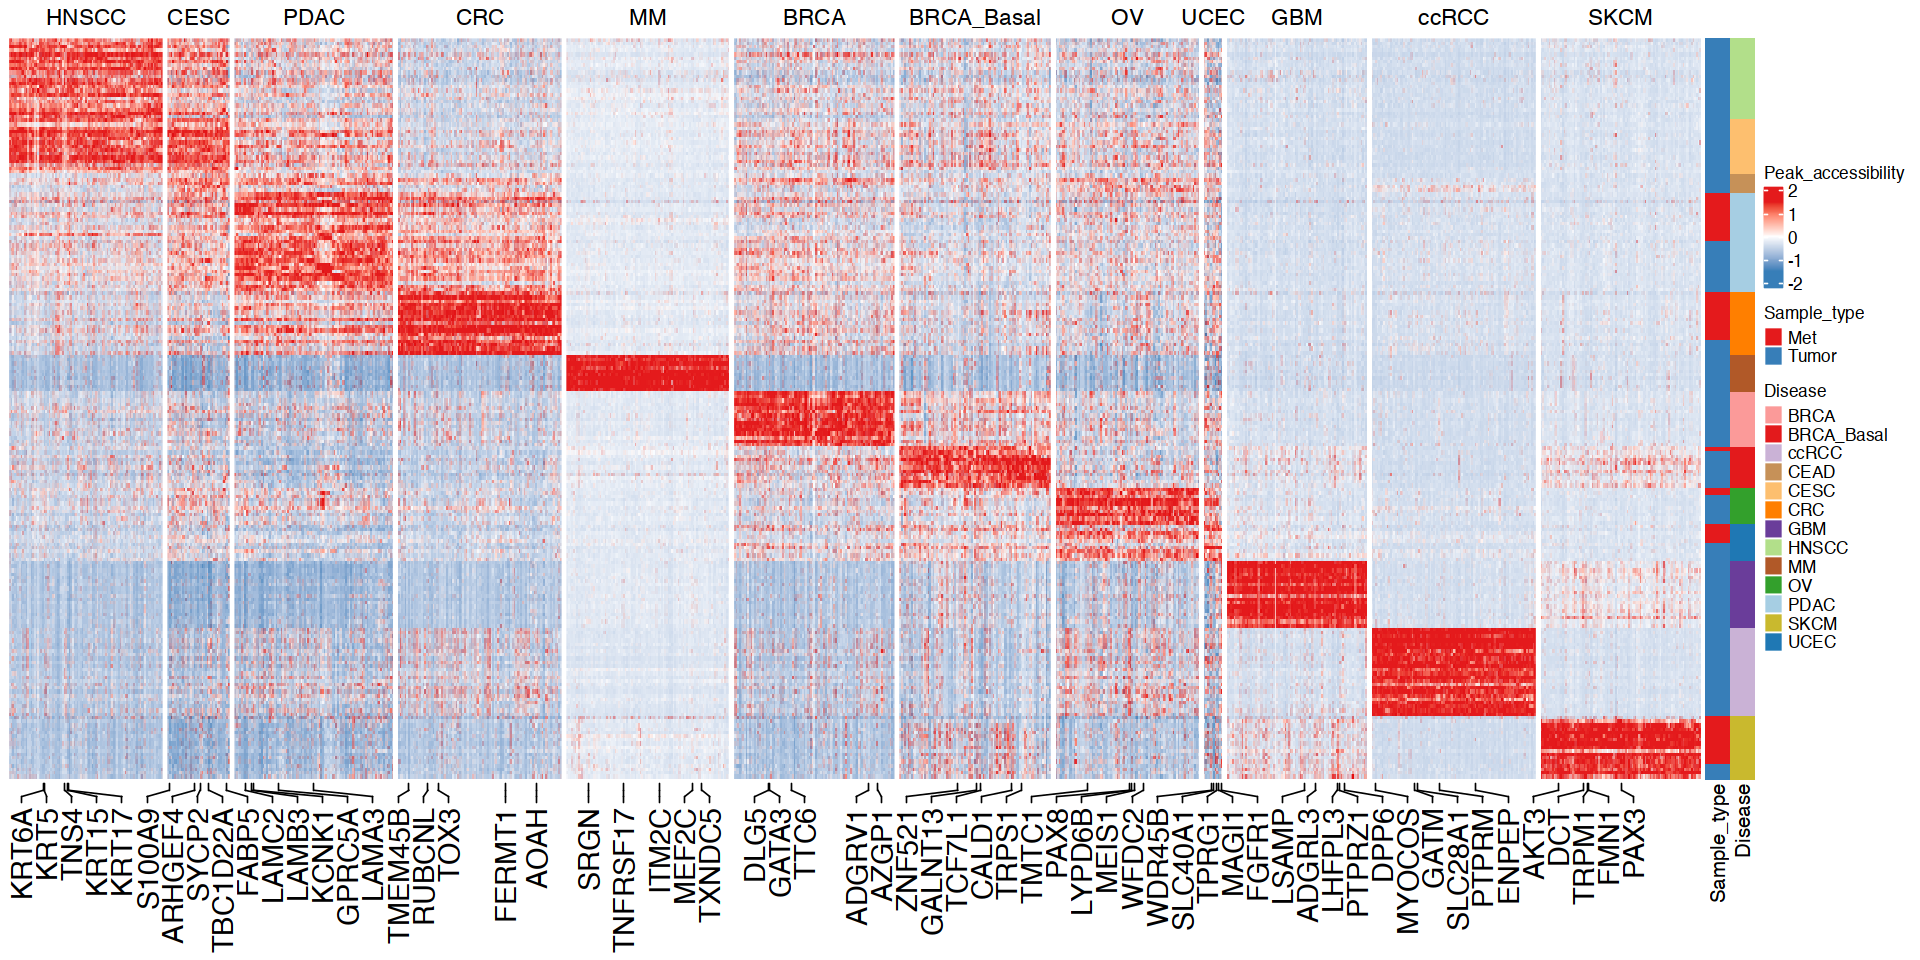

In [17]:
options(repr.plot.width=16, repr.plot.height=8)
x